In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 

from dedalus import public as de
from dedalus.extras import plot_tools

In [8]:
# Domain
L = 20
H = 10

# Wave field
h  = 1
lx = 2 
ly = 1 
US = 1 # Arbitrary because problem is linear

# Environment: R = (N * h / f)^2 = ?
f = 1.0
N = 10

# Numerics
nx = 32
nz = 32

In [9]:
# Create bases and domain
x_basis = de.Fourier('x',   nx, interval=(-L/2, L/2))
y_basis = de.Fourier('y',   nx, interval=(-L/2, L/2))
z_basis = de.Chebyshev('z', nz, interval=(-H, 0)) 

domain = de.Domain([x_basis, y_basis, z_basis], grid_dtype=np.float64)

In [10]:
problem = de.LBVP(domain, variables=['ψ', 'ψz'])

problem.parameters["h"] = h 
problem.parameters["lx"] = lx
problem.parameters["ly"] = ly
problem.parameters["f"] = f 
problem.parameters["N"] = N 
problem.parameters["US"] = US

problem.substitutions["uSy"] = "- y / ly**2 * US * exp(z/h - x**2 / (2 * lx**2) - y**2 / (2 * ly**2))"

problem.add_equation("dx(dx(ψ)) + dy(dy(ψ)) + f**2 / N**2 * dz(ψz) = - uSy",
                     condition="(nx != 0) or (ny != 0)")

problem.add_equation("ψ = 0", condition="(nx == 0) and (ny == 0)")
problem.add_equation("ψz = 0", condition="(nx == 0) and (ny == 0)")
problem.add_equation("dz(ψ) - ψz = 0", condition="(nx != 0) or (ny != 0)")

problem.add_bc("left(ψz) = 0", condition="(nx != 0) or (ny != 0)")
problem.add_bc("right(ψz) = 0", condition="(nx != 0) or (ny != 0)")

# Build solver
solver = problem.build_solver()
solver.solve()

2020-04-18 23:36:18,631 pencil 0/1 INFO :: Building pencil matrix 1/496 (~0%) Elapsed: 0s, Remaining: 4s, Rate: 1.2e+02/s
2020-04-18 23:36:19,055 pencil 0/1 INFO :: Building pencil matrix 50/496 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 1.2e+02/s
2020-04-18 23:36:19,603 pencil 0/1 INFO :: Building pencil matrix 100/496 (~20%) Elapsed: 1s, Remaining: 4s, Rate: 1.0e+02/s
2020-04-18 23:36:20,092 pencil 0/1 INFO :: Building pencil matrix 150/496 (~30%) Elapsed: 1s, Remaining: 3s, Rate: 1.0e+02/s
2020-04-18 23:36:20,502 pencil 0/1 INFO :: Building pencil matrix 200/496 (~40%) Elapsed: 2s, Remaining: 3s, Rate: 1.1e+02/s
2020-04-18 23:36:20,895 pencil 0/1 INFO :: Building pencil matrix 250/496 (~50%) Elapsed: 2s, Remaining: 2s, Rate: 1.1e+02/s
2020-04-18 23:36:21,306 pencil 0/1 INFO :: Building pencil matrix 300/496 (~60%) Elapsed: 3s, Remaining: 2s, Rate: 1.1e+02/s
2020-04-18 23:36:21,845 pencil 0/1 INFO :: Building pencil matrix 350/496 (~71%) Elapsed: 3s, Remaining: 1s, Rate: 1.1e+02/s
2020

In [11]:
ψ = solver.state['ψ']

u_op = - de.operators.differentiate(ψ, y=1)
v_op =   de.operators.differentiate(ψ, x=1)

u = u_op.evaluate()
v = v_op.evaluate()

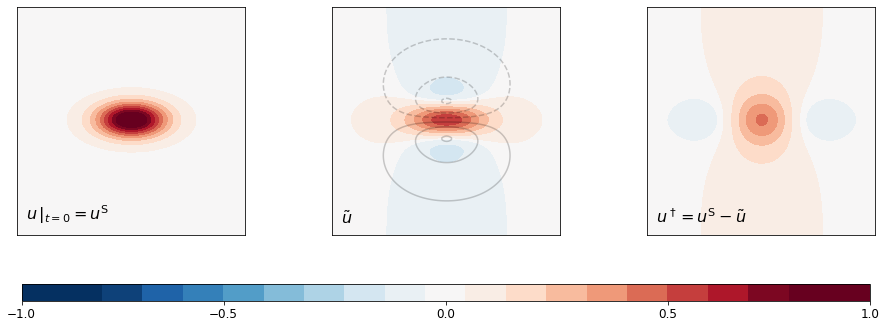

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot solution
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(ncols=3, figsize=(16, 6), sharey=True) 
scale = 4 

x = domain.grid(0, scales=scale)
y = domain.grid(1, scales=scale)
z = domain.grid(2, scales=scale)

X, Y = np.meshgrid(x, y)

Yz, Zy = np.meshgrid(y, z)

ψ.set_scales(scale)
ψ.require_grid_space()

u.set_scales(scale)
u.require_grid_space()

v.set_scales(scale)
v.require_grid_space()

uS = domain.new_field(name='uM')
uM = domain.new_field(name='uM')
vM = domain.new_field(name='vM')

uS.set_scales(scale)
uM.set_scales(scale)
vM.set_scales(scale)

uS.require_grid_space()
uM.require_grid_space()
vM.require_grid_space()

uS['g'] = US * np.exp(z/h - x**2 / (2 * lx**2) - y**2 / (2 * ly**2))
uM['g'] = uS['g'] - u['g']
vM['g'] = - v['g']

ψ_surface_op = de.operators.interpolate(ψ, z=0)
u_surface_op = de.operators.interpolate(u, z=0)
v_surface_op = de.operators.interpolate(v, z=0)

uM_surface_op = de.operators.interpolate(uM, z=0)

uM_surface = uM_surface_op.evaluate()
u_surface = u_surface_op.evaluate()
ψ_surface = ψ_surface_op.evaluate()

uM_surface.set_scales(scale)
ψ_surface.set_scales(scale)
u_surface.set_scales(scale)

ulim = 0.8 * US #np.max(np.abs(u['g']))
ψmax = np.max(np.abs(ψ['g']))

levs = np.array([-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.02, 
                 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) * US

plt.sca(axs[0])

im0 = plt.contourf(X, Y, uS['g'][:, :, -1].T / US, cmap="RdBu_r", 
                  levels=levs, vmin=-ulim, vmax=ulim)

plt.sca(axs[1])

im0 = plt.contourf(X, Y, u_surface['g'][:, :, -1].T / US, cmap="RdBu_r", 
                  levels=levs, vmin=-ulim, vmax=ulim)

plt.contour(X, Y, ψ_surface['g'][:, :, -1].T, levels=np.linspace(-ψmax, ψmax, num=6), 
            colors="k", alpha=0.2)

plt.sca(axs[2])
im1 = plt.contourf(X, Y, uM_surface['g'][:, :, -1].T / US, cmap="RdBu_r",
                   levels=levs, vmin=-ulim, vmax=ulim)

cb = plt.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.95, aspect=50, orientation="horizontal")

cb.set_ticks([-1, -0.5, 0.0, 0.5, 1.0])

axs[0].set_aspect(1)
axs[1].set_aspect(1)
axs[2].set_aspect(1)

plt.text(0.04, 0.04, '$ u \, |_{t=0} = u^\\mathrm{S} $', horizontalalignment='left',
         verticalalignment='bottom', transform=axs[0].transAxes, fontsize=16)

plt.text(0.04, 0.04, '$ \\tilde u $', horizontalalignment='left',
         verticalalignment='bottom', transform=axs[1].transAxes, fontsize=16)

plt.text(0.04, 0.04, '$ u^\\dagger = u^\\mathrm{S} - \\tilde u $', horizontalalignment='left',
         verticalalignment='bottom', transform=axs[2].transAxes, fontsize=16)

#axs[0].set_title("$ u^{\\mathrm{S}} $")
#axs[1].set_title("$ \\tilde{u} $")
#axs[2].set_title("$ u^\\dagger = u^{\\mathrm{S}} - \\tilde{u}$")

axs[0].tick_params(left=False, labelleft=False)

for ax in axs:
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
plt.pause(0.1)

plt.gcf()
plt.savefig('wave_induced_transmitted.png', bbox_inches='tight', dpi=480)

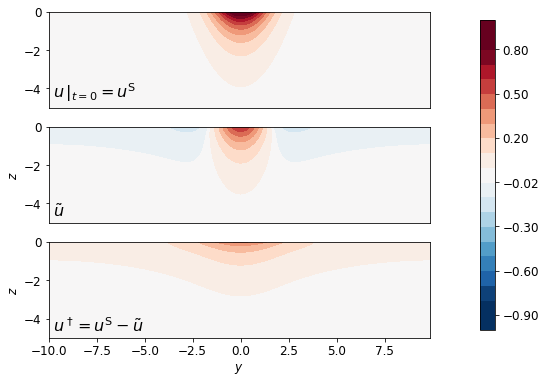

In [13]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 6), sharex=True) 

uS_meridian_op = de.operators.interpolate(uS, x=0)
uS_meridian = uS_meridian_op.evaluate()
uS_meridian.set_scales(scale)

u_meridian_op = de.operators.interpolate(u, x=0)
u_meridian = u_meridian_op.evaluate()
u_meridian.set_scales(scale)

uM_meridian_op = de.operators.interpolate(uM, x=0)
uM_meridian = uM_meridian_op.evaluate()
uM_meridian.set_scales(scale)

levs = np.array([-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.02, 
                 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) * US

ulim = 0.8 * US

plt.sca(axs[0])

im0 = plt.contourf(Yz, Zy, uS_meridian['g'][-1, :, :].T, cmap="RdBu_r", vmin=-ulim, vmax=ulim,
                   levels=levs)

plt.text(0.01, 0.04, '$ u \, |_{t=0} = u^\\mathrm{S} $', horizontalalignment='left',
         verticalalignment='bottom', transform=axs[0].transAxes, fontsize=16)

plt.sca(axs[1])

im1 = plt.contourf(Yz, Zy, u_meridian['g'][-1, :, :].T, cmap="RdBu_r", vmin=-ulim, vmax=ulim,
                   levels=levs)

plt.text(0.01, 0.04, '$ \\tilde u $', horizontalalignment='left',
         verticalalignment='bottom', transform=axs[1].transAxes, fontsize=16)

plt.sca(axs[2])
im2 = plt.contourf(Yz, Zy, uM_meridian['g'][32, :, :].T, cmap="RdBu_r", vmin=-ulim, vmax=ulim,
                   levels=levs)

plt.text(0.01, 0.04, '$ u^\\dagger = u^\\mathrm{S} - \\tilde u$', horizontalalignment='left',
         verticalalignment='bottom', transform=axs[2].transAxes, fontsize=16)

axs[0].set_ylim(-H/2, 0.00)
axs[1].set_ylim(-H/2, 0.00)
axs[2].set_ylim(-H/2, 0.00)

#axs[1].set_xlim(-L/4, L/4)
#axs[2].set_xlim(-L/4, L/4)

axs[0].tick_params(bottom=False, labelbottom=False)
axs[1].tick_params(bottom=False, labelbottom=False)

α = 1
axs[0].set_aspect(α)
axs[1].set_aspect(α)
axs[2].set_aspect(α)

axs[1].set_ylabel("$ z $")
axs[2].set_ylabel("$ z $")
axs[2].set_xlabel("$ y $")

cbar = fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.95)